In [1]:
import datetime
import gc
import pathlib
import random
from typing import Dict, List, Tuple, Union
import sys

from joblib import dump
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder

sys.path.append('..')

from scripts.evaluate import Evaluator
from scripts.get_depth_paths import get_depth_paths
from scripts.get_logger import get_logger
from scripts.merge_dataset import merge_dataset


gc.enable()

In [2]:
class PathHandler:
    competition_dir = pathlib.Path('../../inputs')
    parquet_files_dir = competition_dir.joinpath('parquet_files')
    feature_dir = pathlib.Path('../../outputs/features')
    now_time = datetime.datetime.now()
    output_dir = pathlib.Path(
        f'../../outputs/model_outputs_{now_time.date()}-{now_time.hour:02}-{now_time.minute:02}'
    )
    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)


paths = PathHandler()

In [3]:
bool_features = pd.read_csv(paths.feature_dir.joinpath('bool_features.csv'))
float64_features = pd.read_csv(paths.feature_dir.joinpath('float64_features.csv'))
string_features = pd.read_csv(paths.feature_dir.joinpath('string_features.csv'))
date_features = pd.read_csv(paths.feature_dir.joinpath('date_features.csv'))

bool_features['cast_dtype'] = pl.Boolean
float64_features['cast_dtype'] = pl.Float32
string_features['cast_dtype'] = pl.String
date_features['cast_dtype'] = pl.Date
if paths.feature_dir.joinpath('useful_features.csv').is_file():
    useful_features = pd.read_csv(paths.feature_dir.joinpath('useful_features.csv'))
else:
    useful_features = None
#useful_features = None
display(useful_features)

None

In [4]:
train_depth_paths = get_depth_paths(paths.parquet_files_dir, 'train')
print(f'number of test paths: {sum(len(v1) for v1 in train_depth_paths.values())}')

number of test paths: 31


In [5]:
train_base_data = pl.read_parquet(
    paths.parquet_files_dir.joinpath('train/train_base.parquet')
)
train_base_data = train_base_data.cast(
    {
        'case_id': pl.Int64,
        'date_decision': pl.String,
        'MONTH': pl.Int64,
        'WEEK_NUM': pl.Int64,
        'target': pl.Int64,
    }
)
display(train_base_data)

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1
…,…,…,…,…
2703450,"""2020-10-05""",202010,91,0
2703451,"""2020-10-05""",202010,91,0
2703452,"""2020-10-05""",202010,91,0


In [6]:
%%time


depth_data = merge_dataset(
    train_base_data,
    train_depth_paths,
    bool_features,
    float64_features,
    string_features,
    date_features,
    useful_features,
    '012'
)
display(depth_data)
display(depth_data.dtypes.value_counts())

loading `static_0`
	(1003757, 168)
	(522902, 168)
loading `static_cb_0`
	(1500476, 53)
loading `applprev_1`


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
i64,f32,f32,date,f32,str,f32,date,f32,f32,f32,f32,str,f32,f32,str,f32,date,str,f32,date,date,str,date,str,date,str,bool,bool,f32,f32,i64,f32,f32,str,str,str,str,f32,str,f32
2,0.0,640.200012,null,null,"""a55475b1""",0.0,2013-04-03,null,0.0,null,null,null,null,10000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""",2010-02-15,"""SINGLE""",2013-05-04,"""CASH""",false,true,8200.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",24.0
2,0.0,1682.400024,null,null,"""a55475b1""",0.0,2013-04-03,null,0.0,null,null,null,null,16000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""",2010-02-15,"""SINGLE""",2013-05-04,"""CASH""",false,true,8200.0,null,1,null,12.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",12.0
3,0.0,6140.0,null,null,"""P94_109_143""",null,2019-01-07,null,0.0,null,null,null,null,59999.800781,"""CAL""",null,null,"""P131_33_167""",0.0,null,null,"""P97_36_170""",2018-05-15,"""MARRIED""",2019-02-07,"""CASH""",false,true,11000.0,null,0,null,12.0,"""a55475b1""","""a55475b1""","""P94_109_143""","""a55475b1""",null,"""D""",12.0
4,0.0,2556.600098,null,null,"""P24_27_36""",null,2019-01-08,null,0.0,null,null,null,null,40000.0,"""CAL""",null,null,"""P194_82_174""",0.0,null,null,"""a55475b1""",null,null,2019-02-08,"""CASH""",false,true,16000.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",24.0
5,0.0,null,null,null,"""P85_114_140""",null,2019-01-16,null,null,null,null,null,null,null,null,null,null,"""P54_133_26""",null,null,null,"""a55475b1""",null,null,null,null,false,true,62000.0,null,0,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2651092,0.0,0.0,null,null,"""P94_109_143""",null,2018-05-04,null,100000.0,null,null,null,null,100000.0,"""REL""",null,null,"""P147_21_170""",0.0,null,null,"""a55475b1""",null,null,null,"""NDF""",true,false,28000.0,null,3,null,null,"""P46_145_78""","""a55475b1""","""P99_56_166""","""P94_109_143""",null,"""D""",null
2651092,0.0,4366.0,2017-11-09,null,"""a55475b1""",null,2017-11-09,null,0.0,null,null,null,null,19638.0,"""COL""",0.0,2017-11-15,"""P147_21_170""",0.0,2018-04-03,2018-04-03,"""a55475b1""",null,"""LIVING_WITH_PA…",2017-12-10,"""POS""",false,true,40000.0,0.0,4,0.0,5.0,"""P60_146_156""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""K""",5.0
2651092,0.0,2632.199951,2015-12-11,1.0,"""a55475b1""",1.0,2015-12-11,null,0.0,null,null,null,null,25000.0,"""CAL""",0.0,2015-12-11,"""P147_21_170""",0.0,2017-02-08,2017-02-08,"""P97_36_170""",2004-09-15,"""MARRIED""",2016-01-10,"""CASH""",false,true,72000.0,0.0,5,0.0,14.0,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""K""",14.0


	(782997, 40)


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L
i64,f32,f32,date,f32,str,f32,date,f32,f32,f32,f32,str,f32,f32,str,f32,date,str,f32,date,date,str,date,str,date,str,bool,bool,f32,f32,i64,f32,f32,str,str,str,str,f32,str,f32
40704,0.0,7204.600098,null,null,"""P94_109_143""",null,2018-11-20,null,0.0,null,null,null,null,54000.0,"""CAL""",null,null,"""P147_6_101""",0.0,null,null,"""a55475b1""",null,null,2018-12-20,"""CASH""",false,true,40000.0,null,0,null,12.0,"""P46_145_78""","""a55475b1""","""P198_131_9""","""P94_109_143""",null,"""D""",12.0
40734,0.0,3870.199951,null,null,"""P94_109_143""",null,2019-12-26,null,0.0,null,null,null,null,50000.0,"""CAL""",null,null,"""P111_148_100""",0.0,null,null,"""a55475b1""",null,null,2020-01-26,"""CASH""",false,true,50000.0,null,0,null,18.0,"""P149_40_170""","""a55475b1""","""P45_84_106""","""P94_109_143""",null,"""D""",18.0
40737,0.0,2324.400146,null,1.0,"""a55475b1""",0.0,2014-07-17,null,0.0,null,null,null,null,30000.0,"""CAL""",0.0,null,"""a55475b1""",0.0,null,null,"""P97_36_170""",2014-01-15,"""MARRIED""",2014-08-17,"""CASH""",false,true,16000.0,null,0,0.0,18.0,"""P46_145_78""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",18.0
40791,0.0,3044.400146,null,null,"""P94_109_143""",null,2017-08-21,null,0.0,null,null,null,null,44840.0,"""COL""",null,null,"""P19_11_176""",0.0,null,null,"""a55475b1""",null,null,2017-09-21,"""POS""",false,true,30000.0,null,0,null,24.0,"""P177_117_192""","""a55475b1""","""P99_56_166""","""P94_109_143""",null,"""D""",24.0
40791,0.0,2320.800049,null,1.0,"""a55475b1""",0.0,2014-12-28,null,0.0,null,null,null,null,27830.0,"""COL""",0.0,null,"""a55475b1""",0.0,null,null,"""P97_36_170""",2013-04-15,"""SINGLE""",2015-01-28,"""POS""",false,true,16000.0,null,1,0.0,12.0,"""P60_146_156""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",12.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2703453,0.0,927.799988,2014-01-22,null,"""a55475b1""",0.0,2014-01-22,null,0.0,null,null,null,null,10000.0,"""CAL""",0.0,2014-01-23,"""P123_6_84""",0.0,null,null,"""P97_36_170""",null,"""MARRIED""",2014-02-22,"""CASH""",false,true,7000.0,7.0,6,0.0,18.0,"""P177_117_192""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""K""",18.0
2703453,0.0,266.800018,2013-06-29,null,"""a55475b1""",0.0,2013-06-29,null,0.0,null,null,null,null,2198.0,"""COL""",0.0,2013-07-02,"""P123_6_84""",0.0,null,null,"""P97_36_170""",null,"""MARRIED""",2013-07-29,"""POS""",false,true,7000.0,0.0,7,0.0,12.0,"""P177_117_192""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""K""",12.0
2703453,0.0,416.200012,null,null,"""a55475b1""",0.0,2013-06-29,null,0.0,null,null,null,null,2198.0,"""COL""",0.0,null,"""P123_6_84""",0.0,null,null,"""P97_36_170""",null,"""MARRIED""",2013-07-29,"""POS""",false,true,7000.0,null,8,0.0,6.0,"""P177_117_192""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",6.0


	(438525, 40)
loading `other_1`


case_id,amtdebitincoming_4809443A,amtdebitoutgoing_4809440A,amtdepositbalance_4809441A,amtdepositincoming_4809444A,amtdepositoutgoing_4809442A,num_group1
i64,f32,f32,f32,f32,f32,i64
43801,12466.600586,12291.200195,914.200012,0.0,304.800018,0
43991,3333.400146,3273.400146,0.0,0.0,0.0,0
44001,10000.0,10000.0,0.0,0.0,0.0,0
44053,0.0,0.0,2586.400146,0.0,88.800003,0
44130,63.799999,60.799999,0.0,0.0,0.0,0
…,…,…,…,…,…,…
2703443,344.600006,343.399994,0.0,0.0,0.0,0
2703448,0.0,0.0,2184.199951,0.0,18.0,0
2703450,0.0,0.0,0.0,0.0,0.0,0


	(51109, 6)
loading `tax_registry_a_1`


case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D
i64,f32,str,i64,date
28631,1946.0,"""f980a1ea""",2,2019-09-13
28631,711.0,"""f980a1ea""",3,2019-09-13
28631,3616.400146,"""f980a1ea""",0,2019-09-13
28631,2600.0,"""f980a1ea""",1,2019-09-13
28632,2564.0,"""5f9b74f5""",5,2019-09-13
…,…,…,…,…
2701515,356.0,"""5e180ef0""",7,2020-10-09
2701515,479.800018,"""5e180ef0""",6,2020-10-09
2702290,850.0,"""94721311""",1,2020-10-13


	(457934, 4)
loading `tax_registry_b_1`


case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
i64,f32,date,str,i64
49435,6885.0,2019-10-16,"""6b730375""",7
49435,6885.0,2019-10-16,"""6b730375""",1
49435,6885.0,2019-10-16,"""6b730375""",8
49435,6885.0,2019-10-16,"""6b730375""",3
49435,6885.0,2019-10-16,"""6b730375""",4
…,…,…,…,…
2703452,7290.0,2020-06-11,"""ad68e80f""",2
2703452,10638.0,2020-08-05,"""ad68e80f""",4
2703452,15552.0,2020-07-07,"""3ba7682e""",3


	(150732, 4)
loading `tax_registry_c_1`


case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D
i64,str,i64,f32,date
357,"""c91b12ff""",5,1100.0,2018-08-08
357,"""c91b12ff""",1,1200.0,2018-11-28
357,"""c91b12ff""",4,1200.0,2018-09-10
357,"""c91b12ff""",0,1200.0,2019-01-04
357,"""c91b12ff""",3,628.600037,2018-10-08
…,…,…,…,…
2629815,"""378c3e37""",10,1961.200073,2019-10-22
2629815,"""378c3e37""",1,1961.200073,2019-10-22
2629815,"""378c3e37""",6,1961.200073,2019-10-22


	(482265, 4)
loading `credit_bureau_a_1`


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,…,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
i64,f32,f32,str,str,str,str,f32,f32,f32,date,date,date,date,date,f32,f32,str,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,date,date,f32,f32,f32,f32,i64,f32,…,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,date,f32,f32,str,str,f32,f32,f32,f32,f32,f32
388,null,null,"""4408ff0f""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,2023-06-20,null,null,2018-06-20,null,374419.5,0.0,"""a55475b1""",0.0,null,null,7.0,2018.0,null,"""a55475b1""","""55b002a9""",null,null,null,2019-01-24,null,7811.446289,null,null,null,0,2.0,…,0.0,null,null,null,0.0,null,null,260093.703125,null,0.0,0.0,null,null,null,0.0,null,null,7.0,2018.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""ab3c25cf""","""ab3c25cf""",null,268897.625,0.0,0.0,374419.5,0.0
388,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,135806.0,2020-08-06,null,null,2018-08-06,null,null,null,"""a55475b1""",0.0,null,null,8.0,2018.0,null,"""a55475b1""","""P204_66_73""",8742.799805,null,null,2019-01-11,null,8742.799805,null,null,null,1,null,…,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,8.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,114325.804688,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",2019-01-28,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,3,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",2019-01-28,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,

	(335275, 78)


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,…,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
i64,f32,f32,str,str,str,str,f32,f32,f32,date,date,date,date,date,f32,f32,str,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,date,date,f32,f32,f32,f32,i64,f32,…,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,date,f32,f32,str,str,f32,f32,f32,f32,f32,f32
19694,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,0.0,2020-09-29,null,null,2014-09-29,null,43315.261719,0.0,"""a55475b1""",20.0,null,null,12.0,2017.0,null,"""a55475b1""","""P204_66_73""",0.0,null,null,2019-06-27,null,0.0,null,null,null,0,2.0,…,22.0,null,null,2017-11-21,0.0,null,null,null,null,0.0,2967.666016,null,null,2018-03-31,2967.666016,null,null,4.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,0.0,"""ab3c25cf""","""ab3c25cf""",null,null,0.0,0.0,43315.261719,0.0
19694,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,2020-04-14,null,null,2016-04-14,null,null,null,"""a55475b1""",19.0,null,null,3.0,2018.0,null,"""a55475b1""","""P150_136_157""",null,null,null,2019-07-03,null,5155.54248,null,null,null,1,null,…,21.0,null,null,2018-03-08,0.0,null,null,43315.261719,null,0.0,5155.344238,null,null,2017-01-19,5061.540039,null,null,10.0,2017.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,170000.0,null,null,null,null
19694,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",2019-07-10,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
19694,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,3,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",2019-07-10,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
19694,null,null,"""a55475b1""","""a55475b1

	(549263, 78)


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,…,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
i64,f32,f32,str,str,str,str,f32,f32,f32,date,date,date,date,date,f32,f32,str,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,date,date,f32,f32,f32,f32,i64,f32,…,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,date,f32,f32,str,str,f32,f32,f32,f32,f32,f32
40626,null,null,"""ea6782cc""","""ea6782cc""","""7241344e""","""7241344e""",null,0.0,null,2022-03-31,2019-09-14,2017-09-14,2018-10-31,2018-12-19,200944.125,0.0,"""a55475b1""",0.0,0.0,10.0,11.0,2018.0,2017.0,"""P204_66_73""","""0d39f5db""",null,0.0,null,2019-12-13,2018-12-29,6806.784668,0.0,null,null,0,3.0,…,0.0,0.0,null,null,0.0,0.0,null,141063.484375,0.0,0.0,0.0,0.0,null,null,0.0,0.0,10.0,11.0,2018.0,2017.0,null,30.0,null,null,"""96a8fdfe""","""60c73645""",2020-01-01,0.0,null,"""ab3c25cf""","""ab3c25cf""",null,180000.0,0.0,0.0,200944.125,0.0
40626,68.300003,null,"""ea6782cc""","""01f63ac8""","""7241344e""","""7241344e""",null,null,66978.0,2021-03-24,2019-10-04,2019-09-04,2019-03-24,2019-10-01,null,null,"""a55475b1""",0.0,0.0,9.0,4.0,2019.0,2019.0,"""9a93e20f""","""P204_66_73""",7990.200195,null,null,2019-12-12,2019-10-01,7990.200195,0.0,null,68.300003,1,null,…,0.0,0.0,null,null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,null,0.0,0.0,9.0,4.0,2019.0,2019.0,null,null,0.0,null,"""60c73645""","""96a8fdfe""",2019-12-31,null,40809.855469,"""a55475b1""","""a55475b1""",4000.0,null,null,null,null,null
40626,38.299999,null,"""ea6782cc""","""01f63ac8""","""7241344e""","""7241344e""",null,null,20000.0,2021-03-24,2019-10-31,2019-10-01,2019-03-24,2019-10-30,null,null,"""a55475b1""",0.0,0.0,10.0,4.0,2019.0,2019.0,"""9a93e20f""","""P204_66_73""",7952.399902,null,null,2019-12-11,2019-10-30,7952.399902,0.0,null,38.299999,2,null,…,0.0,0.0,null,null,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,null,0.0,0.0,10.0,4.0,2019.0,2019.0,null,null,0.0,null,"""60c73645""","""96a8fdfe""",2020-01-01,null,19070.800781,"""a55475b1""","""a55475b1""",6000.0,null,null,null,null,null
40626,96.300003,null,"""a55475b1""","""01f63ac8""","""a55475b1""","""7241344e""",null,null,null,null,2019-12-06,2019-11-06,null,2019-12-06,null,null,"""a55475b1""",null,0.0,11.0,null,null,2019.0,"""9a93e20f""","""a55475b1""",null,null,null,null,2019-12-06,null,0.0,null,96.300003,3,null,…,null,0.0,null,null,null,0.0,0.0,null,0.0,null,null,0.0,null,null,null,0.0,11.0,null,null,2019.0,null,null,0.0,null,"""a55475b1""","""96a8fdfe""

	(325127, 78)


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,…,numberofoverdueinstlmax_1039L,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A
i64,f32,f32,str,str,str,str,f32,f32,f32,date,date,date,date,date,f32,f32,str,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,date,date,f32,f32,f32,f32,i64,f32,…,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,date,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,date,f32,f32,str,str,f32,f32,f32,f32,f32,f32
51903,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",13591.0,null,30000.0,2021-11-30,null,null,2019-11-30,null,10602.110352,0.0,"""a55475b1""",0.0,null,null,12.0,2019.0,null,"""a55475b1""","""b619fa46""",2718.199951,null,null,2020-06-13,null,2718.199951,null,null,null,0,2.0,…,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,12.0,2019.0,null,null,null,null,null,"""60c73645""","""a55475b1""",2020-06-25,null,2718.199951,"""ab3c25cf""","""a55475b1""",null,null,0.0,null,10602.110352,null
51903,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",39419.550781,null,11260.0,2022-01-26,null,null,2020-01-26,null,null,null,"""a55475b1""",0.0,null,null,2.0,2020.0,null,"""a55475b1""","""b619fa46""",1070.400024,null,null,2020-06-17,null,1070.400024,null,null,null,1,null,…,0.0,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,2.0,2020.0,null,null,null,null,null,"""60c73645""","""a55475b1""",2020-06-25,null,7883.910156,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
51903,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",2020-06-25,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
51903,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,3,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null
51903,null,null,"""a55475b1""","""a55475b1""","""a55475

	(176608, 78)
loading `credit_bureau_b_1`


case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,credor_3940957M,credquantity_1099L,credquantity_984L,debtpastduevalue_732A,debtvalue_227A,dpd_550P,dpd_733P,dpdmax_851P,dpdmaxdatemonth_804T,dpdmaxdateyear_742T,installmentamount_644A,installmentamount_833A,instlamount_892A,interesteffectiverate_369L,interestrateyearly_538L,lastupdate_260D,maxdebtpduevalodued_3940955A,num_group1,numberofinstls_810L,overdueamountmax_950A,overdueamountmaxdatemonth_494T,overdueamountmaxdateyear_432T,periodicityofpmts_997L,periodicityofpmts_997M,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A
i64,f32,str,date,date,str,str,f32,f32,f32,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,date,f32,i64,f32,f32,f32,f32,str,str,f32,str,f32,str,f32,f32,f32,str,str,f32,f32
467,null,"""ea6782cc""",2011-06-15,2031-06-13,"""7241344e""","""724be82a""",3e6,10000.0,3e6,"""P164_34_168""",2.0,1.0,null,null,0.0,0.0,null,null,null,0.0,0.0,null,null,null,2019-01-20,null,0,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",0.0,0.0,null,"""fa4f56f1""","""ab3c25cf""",3e6,10000.0
467,null,"""ea6782cc""",2019-01-04,2021-08-04,"""7241344e""","""724be82a""",null,null,130365.0,"""P164_34_168""",1.0,2.0,null,null,0.0,0.0,null,null,null,0.0,26571.96875,null,null,null,2019-01-20,null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",78000.0,960000.0
467,78000.0,"""ea6782cc""",2016-10-25,2019-10-25,"""7241344e""","""4257cbed""",null,null,null,"""c5a72b57""",null,null,0.0,26571.96875,null,null,0.0,11.0,2016.0,null,null,2898.76001,null,null,2019-01-10,0.0,2,36.0,0.0,11.0,2016.0,null,"""a0b598e4""",0.0,"""e914c86c""",10.0,"""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",null,null
1445,null,"""ea6782cc""",2015-01-30,2021-01-30,"""7241344e""","""1c9c5356""",400000.0,100000.0,74000.0,"""b619fa46""",2.0,5.0,0.0,null,0.0,0.0,200418.0,1.0,2018.0,0.0,0.0,null,null,null,2019-01-19,0.4,0,null,1.4,2.0,2018.0,null,"""a55475b1""",0.0,"""a55475b1""",null,"""60c73645""",0.0,0.0,73044.179688,"""daf49a8a""","""ab3c25cf""",400000.0,100000.0
1445,null,"""01f63ac8""",2014-09-12,2021-09-12,"""7241344e""","""724be82a""",null,null,400000.0,"""74bd67a8""",3.0,17.0,null,null,0.0,0.0,null,null,null,0.0,209617.765625,null,null,null,2019-01-13,null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",396800.625,184587.796875
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2703357,null,"""ea6782cc""",2018-11-17,2020-11-17,"""7241344e""","""1c9c5356""",72000.0,68996.0,72000.0,"""b619fa46""",1.0,4.0,0.0,null,0.0,0.0,38126.0,7.0,2019.0,0.0,72000.0,null,null,null,2020-10-04,0.2,0,null,0.4,7.0,2020.0,null,null,0.0,"""a55475b1""",null,"""60c73645""",0.0,72000.0,72000.0,"""ab3c25cf""","""ab3c25cf""",72000.0,68996.0
2703357,731886.0625,"""07b11743""",2018-04-17,2023-04-17,"""7241344e""","""4257cbed""",null,null,null,"""904adb51""",1.0,3.0,0.0,185141.03125,0.0,0.0,185729.0,3.0,2020.0,0.0,185141.03125,7950.657715,null,null,2020-10-19,8.6,1,61.0,10.400001,6.0,2020.0,"""Ежемесячные пл…",null,0.0,"""e914c86c""",31.0,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",731886.0625,490729.21875
2703377,null,"""ea6782cc""",2014-01-04,2022-01-04,"""7241344e""","""1c9c5356""",0.0,null,0.0,"""b619fa46""",1.0,5.0,0.0,null,0.0,0.0,15304.0,9.0,2015.0,0.0,0.0,null,null,null,2020-10-02,0.2,0,null,1.0,12.0,2015.0,null,null,0.0,"""a55475b1""",null,"""60c73645""",null,0.0,0.0,"""ab3c25cf""","""ab3c25cf""",0.0,205540.0


	(36500, 44)
loading `deposit_1`


case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D
i64,f32,date,i64,date
225,0.0,null,0,2016-08-16
331,260.373993,2018-03-18,0,2015-03-19
358,0.0,null,0,2014-09-02
390,211748.53125,2017-07-22,0,2014-07-23
390,223.680008,null,2,2016-06-08
…,…,…,…,…
2703430,22918.005859,null,8,2016-11-26
2703430,0.0,null,2,2014-02-14
2703439,219.984009,null,0,2016-11-25


	(105111, 4)
loading `person_1`


case_id,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,num_group1,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L
i64,date,date,f32,str,bool,bool,str,str,date,str,str,str,str,str,str,str,str,str,bool,str,f32,str,i64,f32,f32,f32,str,str,str,str,bool,str,str,bool,str,str
0,1986-07-01,null,null,"""P88_18_84""",false,false,"""P167_100_165""","""P97_36_170""",2017-09-15,"""MORE_FIVE""","""OTHER""","""P142_57_166""","""P167_100_165""","""MARRIED""",null,null,null,"""SALARIED_GOVT""",true,"""P10_39_147""",10800.0,null,0,0.0,1.0,1.0,"""P88_18_84""","""P167_100_165""",null,null,true,"""CL""",null,true,"""F""","""PRIMARY_MOBILE…"
0,null,null,null,"""a55475b1""",true,true,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,true,"""a55475b1""",null,null,1,1.0,1.0,4.0,"""a55475b1""","""a55475b1""","""SPOUSE""",null,false,"""EM""",null,true,null,"""PHONE"""
0,null,null,null,"""a55475b1""",true,true,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,true,"""a55475b1""",null,null,2,2.0,4.0,5.0,"""a55475b1""","""a55475b1""","""COLLEAGUE""","""SPOUSE""",false,"""PE""",null,true,null,"""PHONE"""
0,null,null,null,"""a55475b1""",true,true,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,true,"""a55475b1""",null,null,3,null,5.0,null,"""a55475b1""","""a55475b1""",null,"""COLLEAGUE""",true,"""PE""",null,true,null,"""PHONE"""
1,1957-08-01,null,null,"""P103_93_94""",false,false,"""P176_37_166""","""P97_36_170""",2008-10-29,"""MORE_FIVE""","""OTHER""","""P49_46_174""","""P160_59_140""","""DIVORCED""",null,null,null,"""SALARIED_GOVT""",true,"""P10_39_147""",10000.0,null,0,0.0,1.0,1.0,"""P103_93_94""","""P176_37_166""",null,null,true,"""CL""",null,true,"""M""","""PRIMARY_MOBILE…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2703451,null,null,null,"""a55475b1""",true,true,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,true,"""a55475b1""",null,null,1,null,1.0,null,"""a55475b1""","""a55475b1""",null,null,true,"""CL""",null,true,null,"""HOME_PHONE"""
2703452,1977-08-01,null,null,"""P133_44_167""",false,false,"""P59_150_74""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,"""PRIVATE_SECTOR…",true,"""P209_127_106""",30000.0,null,0,0.0,1.0,1.0,"""P19_11_176""","""P11_15_81""",null,null,true,"""CL""",null,false,"""M""","""PRIMARY_MOBILE…"
2703453,1950-02-01,null,null,"""P123_6_84""",false,false,"""P46_103_143""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,"""RETIRED_PENSIO…",true,"""P209_127_106""",30000.0,null,0,0.0,1.0,1.0,"""P123_6_84""","""P46_103_143""",null,null,true,"""CL""",null,false,"""F""","""PRIMARY_MOBILE…"


	(1526659, 36)
loading `debitcard_1`


case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D
i64,f32,f32,f32,i64,date
225,null,null,null,0,2016-08-16
331,null,null,null,0,2015-03-19
358,null,null,null,0,2014-09-02
390,null,null,null,0,2014-07-23
390,null,null,null,2,2016-06-08
…,…,…,…,…,…
2703430,null,null,null,8,2016-11-26
2703430,null,null,null,2,2014-02-14
2703439,null,null,null,0,2016-11-25


	(111772, 5)
loading `applprev_2`


case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2
i64,str,str,str,i64,i64
2,null,"""EMPLOYMENT_PHO…",null,1,1
2,null,"""EMPLOYMENT_PHO…",null,0,1
2,null,"""PRIMARY_MOBILE…",null,0,0
2,null,"""PRIMARY_MOBILE…",null,1,0
3,null,"""PRIMARY_MOBILE…",null,0,1
…,…,…,…,…,…
2703454,"""a55475b1""","""PRIMARY_MOBILE…",null,0,0
2703454,"""a55475b1""",null,null,1,3
2703454,"""a55475b1""",null,null,0,1


	(1221522, 4)
loading `person_2`


case_id,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,num_group1,num_group2,relatedpersons_role_762T
i64,str,str,str,str,str,date,str,i64,i64,str
5,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""CONTACT""","""P10_68_40""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",0,0,null
6,"""P55_110_32""","""PERMANENT""","""P10_68_40""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,1,null
6,"""P204_92_178""","""CONTACT""","""P65_136_169""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",1,0,"""OTHER_RELATIVE…"
6,"""P191_109_75""","""CONTACT""","""P10_68_40""","""P7_147_157""","""a55475b1""",null,"""a55475b1""",1,1,"""OTHER_RELATIVE…"
…,…,…,…,…,…,…,…,…,…,…
2703450,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
2703451,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null
2703452,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",0,0,null


	(1435041, 9)
loading `credit_bureau_a_2`


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
388,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,6.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2548729,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",2,31,null,null,9.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
2548729,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",2,32,null,null,10.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
2548729,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",2,33,null,null,11.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""


	(98303, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
6683,"""8fd95e4b""","""a55475b1""",6.7428e6,null,"""a55475b1""","""9276e4bb""",0,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""
6683,"""8fd95e4b""","""a55475b1""",6.7e6,null,"""a55475b1""","""0e63c0f0""",0,1,null,null,3.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
6683,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,0.0,null,4.0,null,0.0,null,2017.0,null,"""a55475b1""","""a55475b1"""
6683,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,0.0,null,5.0,null,0.0,null,2017.0,null,"""a55475b1""","""a55475b1"""
6683,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,0.0,null,6.0,null,0.0,null,2017.0,null,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2570525,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,7,null,null,9.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
2570525,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,8,null,null,10.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
2570525,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,9,null,null,11.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""


	(118481, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
56408,"""a55475b1""","""8fd95e4b""",null,0.0,"""3cbe86ba""","""a55475b1""",0,0,null,null,null,2.0,null,null,null,2012.0,"""ab3c25cf""","""a55475b1"""
56408,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,null,3.0,null,null,null,2012.0,"""a55475b1""","""a55475b1"""
56408,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,null,4.0,null,null,null,2012.0,"""a55475b1""","""a55475b1"""
56408,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,null,5.0,null,null,null,2012.0,"""a55475b1""","""a55475b1"""
56408,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,null,6.0,null,null,null,2012.0,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2703454,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",8,19,null,null,null,9.0,null,null,null,2020.0,"""a55475b1""","""a55475b1"""
2703454,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",8,20,null,null,null,10.0,null,null,null,2020.0,"""a55475b1""","""a55475b1"""
2703454,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",8,21,null,null,null,11.0,null,null,null,2020.0,"""a55475b1""","""a55475b1"""


	(23734, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
13927,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""
13927,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
13927,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
13927,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
13927,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,0.0,null,6.0,null,0.0,null,2017.0,null,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2593511,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",5,19,null,null,null,9.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""
2593511,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",5,20,null,null,null,10.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""
2593511,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",5,21,null,null,null,11.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""


	(156749, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
21161,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2017.0,null,"""a55475b1""","""ab3c25cf"""
21161,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
21161,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
21161,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
21161,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,6.0,null,null,null,2017.0,null,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2619253,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",9,19,null,null,null,9.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""
2619253,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",9,20,null,null,null,10.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""
2619253,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",9,21,null,null,null,11.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""


	(190486, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
29427,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2019.0,null,"""a55475b1""","""ab3c25cf"""
29427,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
29427,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2019.0,null,"""a55475b1""","""a55475b1"""
29427,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,0.0,null,5.0,null,0.0,null,2019.0,null,"""a55475b1""","""a55475b1"""
29427,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,0.0,null,6.0,null,0.0,null,2019.0,null,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2640040,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",1,31,null,0.0,null,9.0,null,0.0,null,2018.0,"""a55475b1""","""a55475b1"""
2640040,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",1,32,null,3.0,null,10.0,null,1834.400024,null,2018.0,"""a55475b1""","""a55475b1"""
2640040,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",1,33,null,7.0,null,11.0,null,1834.400024,null,2018.0,"""a55475b1""","""a55475b1"""


	(190313, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
36830,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""3cbe86ba""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2017.0,2013.0,"""ab3c25cf""","""ab3c25cf"""
36830,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,0.0,3.0,3.0,null,0.0,2017.0,2013.0,"""a55475b1""","""a55475b1"""
36830,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,0.0,4.0,4.0,null,0.0,2017.0,2013.0,"""a55475b1""","""a55475b1"""
36830,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,0.0,5.0,5.0,null,0.0,2017.0,2013.0,"""a55475b1""","""a55475b1"""
36830,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,0.0,6.0,6.0,null,0.0,2017.0,2013.0,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2658153,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,31,null,null,null,9.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""
2658153,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,32,null,null,null,10.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""
2658153,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,33,null,null,null,11.0,null,null,null,2019.0,"""a55475b1""","""a55475b1"""


	(231250, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
42865,"""9a0c095e""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf"""
42865,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
42865,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
42865,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
42865,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,6.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2677343,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,19,null,null,9.0,null,null,null,2020.0,null,"""a55475b1""","""a55475b1"""
2677343,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,20,null,null,10.0,null,null,null,2020.0,null,"""a55475b1""","""a55475b1"""
2677343,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,21,null,null,11.0,null,null,null,2020.0,null,"""a55475b1""","""a55475b1"""


	(150426, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
49417,"""9a0c095e""","""8fd95e4b""",0.0,0.0,"""3cbe86ba""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2018.0,2014.0,"""ab3c25cf""","""ab3c25cf"""
49417,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,0.0,3.0,3.0,null,0.0,2018.0,2014.0,"""a55475b1""","""a55475b1"""
49417,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,0.0,4.0,4.0,null,0.0,2018.0,2014.0,"""a55475b1""","""a55475b1"""
49417,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,0.0,9.0,5.0,5.0,0.0,3939.0,2018.0,2014.0,"""a55475b1""","""a55475b1"""
49417,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,0.0,11.0,6.0,6.0,0.0,3678.400146,2018.0,2014.0,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2681255,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",15,19,null,null,null,9.0,null,null,null,2018.0,"""a55475b1""","""a55475b1"""
2681255,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",15,20,null,null,null,10.0,null,null,null,2018.0,"""a55475b1""","""a55475b1"""
2681255,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",15,21,null,null,null,11.0,null,null,null,2018.0,"""a55475b1""","""a55475b1"""


	(45056, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
51083,"""9a0c095e""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2018.0,2007.0,"""ab3c25cf""","""ab3c25cf"""
51083,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,3.0,null,null,2018.0,2007.0,"""a55475b1""","""a55475b1"""
51083,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,4.0,null,null,2018.0,2007.0,"""a55475b1""","""a55475b1"""
51083,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,5.0,null,null,2018.0,2007.0,"""a55475b1""","""a55475b1"""
51083,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,6.0,6.0,null,null,2018.0,2007.0,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2688744,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,19,null,null,9.0,null,null,null,2020.0,null,"""a55475b1""","""a55475b1"""
2688744,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,20,null,null,10.0,null,null,null,2020.0,null,"""a55475b1""","""a55475b1"""
2688744,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,21,null,null,11.0,null,null,null,2020.0,null,"""a55475b1""","""a55475b1"""


	(77457, 17)


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M
i64,str,str,f32,f32,str,str,i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,str,str
53716,"""8fd95e4b""","""9a0c095e""",0.0,0.0,"""c7a5ad39""","""c7a5ad39""",0,0,null,null,2.0,2.0,null,null,2019.0,2017.0,"""ab3c25cf""","""ab3c25cf"""
53716,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,3.0,null,null,2019.0,2017.0,"""a55475b1""","""a55475b1"""
53716,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,4.0,null,null,2019.0,2017.0,"""a55475b1""","""a55475b1"""
53716,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,5.0,null,null,2019.0,2017.0,"""a55475b1""","""a55475b1"""
53716,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,6.0,6.0,null,null,2019.0,2017.0,"""a55475b1""","""a55475b1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2700533,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",7,31,null,0.0,null,9.0,null,0.0,null,2019.0,"""a55475b1""","""a55475b1"""
2700533,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",7,32,null,0.0,null,10.0,null,0.0,null,2019.0,"""a55475b1""","""a55475b1"""
2700533,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",7,33,null,0.0,null,11.0,null,0.0,null,2019.0,"""a55475b1""","""a55475b1"""


	(103033, 17)
loading `credit_bureau_b_2`


case_id,num_group1,num_group2,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
i64,i64,i64,date,f32,f32
467,2,19,2018-05-15,0.0,0.0
467,2,25,2018-11-15,0.0,0.0
467,2,18,2018-04-15,0.0,0.0
467,2,0,2016-10-15,0.0,0.0
467,2,6,2017-04-15,0.0,0.0
…,…,…,…,…,…
2703436,0,10,2019-02-15,0.0,0.0
2703436,1,28,2020-02-15,0.0,0.0
2703436,0,6,2018-10-15,0.0,0.0


	(36446, 4)
(1526659, 469)


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,...,day_contractmaturitydate_151D_1,day_lastupdate_260D_1,day_contractenddate_991D_1,day_openingdate_313D_1,day_birth_259D_1,day_birthdate_87D_1,day_empl_employedfrom_271D_1,day_openingdate_857D_1,day_empls_employedfrom_796D_2,day_pmts_date_1107D_2
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,29.0,NaN,NaN,NaN
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,15.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,NaN,NaN,NaN,18.0,1.0,NaN,NaN,18.0,NaN,NaN


float32    466
object     102
bool        11
int64        4
Name: count, dtype: int64

CPU times: user 1min 13s, sys: 22.6 s, total: 1min 36s
Wall time: 23.9 s


### drop columns which have many nans

In [7]:
ratio_nan = depth_data.isna().sum() / len(depth_data)
display(ratio_nan)

depth_data = depth_data[ratio_nan[ratio_nan < 0.8].index]
display(depth_data)

case_id                          0.000000
date_decision                    0.000000
MONTH                            0.000000
WEEK_NUM                         0.000000
target                           0.000000
                                   ...   
day_birthdate_87D_1              0.991840
day_empl_employedfrom_271D_1     0.628797
day_openingdate_857D_1           0.933812
day_empls_employedfrom_796D_2    0.999999
day_pmts_date_1107D_2            0.976127
Length: 583, dtype: float64

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,...,day_dateofrealrepmt_138D_1,day_lastupdate_1112D_1,day_lastupdate_388D_1,day_numberofoverdueinstlmaxdat_148D_1,day_numberofoverdueinstlmaxdat_641D_1,day_overdueamountmax2date_1002D_1,day_overdueamountmax2date_1142D_1,day_refreshdate_3813885D_1,day_birth_259D_1,day_empl_employedfrom_271D_1
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,29.0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,27.0,8.0,25.0,5.0,NaN,NaN,NaN,17.0,1.0,NaN
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,18.0,8.0,18.0,NaN,NaN,NaN,NaN,17.0,1.0,NaN
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,23.0,30.0,9.0,NaN,NaN,NaN,NaN,17.0,1.0,NaN
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,10.0,8.0,1.0,NaN,NaN,NaN,NaN,17.0,1.0,NaN


### encoding

In [8]:
def encode_objects(
        depth_data: pd.DataFrame,
        output_dir: pathlib.Path
    ) -> pd.DataFrame:

    if not output_dir.is_dir():
        output_dir.mkdir(parents=True)

    object_columns = depth_data.dtypes.index[depth_data.dtypes==object].to_list()
    if 'date_decision' in object_columns:
        object_columns.remove('date_decision')
    print(len(object_columns))
    
    object_data = []
    for col in object_columns:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        encoded_class = encoder.fit_transform(depth_data[col].values.reshape(-1, 1))
        object_data.append(encoded_class.astype(np.float32))
        dump(encoder, output_dir.joinpath(f'encoder_{col}.joblib'))
    depth_data.drop(columns=object_columns, inplace=True)
    object_data = np.concatenate(object_data, axis=1)
    object_data = pd.DataFrame(object_data, columns=object_columns)
    
    return pd.concat([depth_data, object_data], axis=1)

In [9]:
%%time


depth_data = encode_objects(
    depth_data,
    paths.output_dir.joinpath('encoders')
)
display(depth_data)

77


,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,...,addres_zip_823M_2,conts_role_79M_2,empls_economicalst_849M_2,empls_employer_name_740M_2,collater_typofvalofguarant_298M_2,collater_typofvalofguarant_407M_2,collaterals_typeofguarante_359M_2,collaterals_typeofguarante_669M_2,subjectroles_name_541M_2,subjectroles_name_838M_2
0,0,2019-01-03,201901,0,0,NaN,NaN,1917.599976,0.000000,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
1,1,2019-01-03,201901,0,0,NaN,NaN,3134.000000,0.000000,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
2,2,2019-01-04,201901,0,0,NaN,NaN,4937.000000,0.000000,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
3,3,2019-01-03,201901,0,0,NaN,NaN,4643.600098,0.000000,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
4,4,2019-01-04,201901,0,1,NaN,NaN,3390.199951,0.000000,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,176561.359375,3675.400146,0.000000,0.0,...,1458.0,3.0,8.0,1.0,3.0,4.0,13.0,13.0,6.0,6.0
1526655,2703451,2020-10-05,202010,91,0,0.0,301276.468750,7088.600098,6191.600098,0.0,...,1458.0,3.0,8.0,1.0,3.0,4.0,13.0,13.0,6.0,6.0
1526656,2703452,2020-10-05,202010,91,0,0.0,14232.400391,7788.800293,0.000000,0.0,...,1458.0,3.0,8.0,1.0,3.0,4.0,13.0,13.0,6.0,6.0
1526657,2703453,2020-10-05,202010,91,0,0.0,197371.578125,1195.400024,2827.199951,0.0,...,1458.0,3.0,8.0,1.0,3.0,2.0,3.0,13.0,6.0,6.0


CPU times: user 9.85 s, sys: 635 ms, total: 10.5 s
Wall time: 10.5 s


### training

In [10]:
class CFG:
    def __init__(
            self,
            outputs_dir: pathlib.Path,
            n_splits: int = 5,
            lr: float = 0.1,
            max_depth: int = -1,
            num_leaves: int = 31,
            min_data_in_leaf: int = 20,
            bagging_fraction: float = 1.0,
            feature_fraction_bynode: float = 1.0,
            num_boost_round: int = 1000,
            seed: int = 42,
            device: str = 'cpu',
            debag: bool = False,
        ):
        
        self.outputs_dir = outputs_dir
        self.n_splits = n_splits
        self.lr = lr
        self.max_depth = max_depth
        self.num_leaves = num_leaves
        self.min_data_in_leaf = min_data_in_leaf
        self.bagging_fraction = bagging_fraction
        self.feature_fraction_bynode = feature_fraction_bynode
        self.num_boost_round = num_boost_round
        self.seed = seed
        self.device = device
        self.debag = debag
        
    def seed_everything(self):
        random.seed(self.seed)
        np.random.seed(self.seed)

In [11]:
def train(config, logger, Xy):
    
    kfold = StratifiedGroupKFold(
        n_splits=config.n_splits,
        shuffle=True,
        random_state=config.seed,
    )
    
    y = Xy['target'].copy()
    groups = Xy['WEEK_NUM'].copy()
    oof = Xy[['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']].copy()
    oof_probas = -1 * np.ones(len(oof))
    folds = -1 * np.ones(len(oof))
    X = Xy[[col for col in Xy.columns if col not in ['case_id', 'date_decision', 'MONTH', 'WEEK_NUM', 'target']]].copy()
    display(X)
    display(X.dtypes.value_counts())
    display(oof)
    
    np.save(config.outputs_dir.joinpath('training_features.npy'), X.columns.to_numpy())
    
    del Xy
    gc.collect()
    
    fimps = pd.DataFrame(
        index=X.columns,
        columns=[f'fold_{k+1}_fimp' for k in range(config.n_splits)]
    )
    
    model_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': ['average_precision', 'auc', 'binary_logloss'],
        'learning_rate': config.lr,
        'seed': config.seed,
        'max_depth': config.max_depth,
        'num_leaves': config.num_leaves,
        'min_data_in_leaf': config.min_data_in_leaf,
        'bagging_fraction': config.bagging_fraction,
        'feature_fraction_bynode': config.feature_fraction_bynode,
        'device': config.device,
    }
    
    lgb.register_logger(logger) 
    
    for k, (train_indices, valid_indices) in enumerate(kfold.split(X=X, y=y, groups=groups)):
        logger.info(f'fold: {k+1}')
        logger.info(f'# of train: {len(train_indices)}')
        logger.info(f'# of valid: {len(valid_indices)}')

        logger.info(f'train WEEK_NUM: {oof.iloc[train_indices]["WEEK_NUM"].unique()}')
        logger.info(f'valid WEEK_NUM: {oof.iloc[valid_indices]["WEEK_NUM"].unique()}')
        
        train_X = X.iloc[train_indices]
        valid_X = X.iloc[valid_indices]
        
        train_y = y.iloc[train_indices]
        valid_y = y.iloc[valid_indices]
        
        train_dataset = lgb.Dataset(data=train_X, label=train_y)
        valid_dataset = lgb.Dataset(data=valid_X, label=valid_y, reference=train_dataset)
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, first_metric_only=True, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        model = lgb.train(
            params=model_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=config.num_boost_round,
        )

        date = ''.join(config.outputs_dir.stem.split('-')[-4:])
        model.save_model(
            config.outputs_dir.joinpath(f'lgb_fold{k+1}_{date}.txt'),
            num_iteration=model.best_iteration
        )
        
        fimps.loc[train_X.columns, f'fold_{k+1}_fimp'] = model.feature_importance(importance_type='gain')
        
        oof_probas[valid_indices] = model.predict(valid_X, num_iteration=model.best_iteration)
        folds[valid_indices] = k
        
        del train_X, train_y, valid_X, valid_y
        gc.collect()
        
    oof.loc[:, 'probability'] = oof_probas
    oof.loc[:, 'fold'] = folds
    
    del oof_probas, folds
    gc.collect()

    logger.info('Done!\n')
    
    return oof, fimps

In [12]:
%%time


config = CFG(
    outputs_dir=paths.output_dir,
    n_splits=5,
    lr=1e-01,
    max_depth=10,
    min_data_in_leaf=100,
    bagging_fraction=0.8,
    feature_fraction_bynode=0.8,
    num_boost_round=10000,
    seed=42,
    device='CPU',
    debag=False,
)
config.seed_everything()

logger = get_logger(paths.output_dir.joinpath('output.log'))

log = [f'{k} = {config.__dict__[k]}' for k, v in config.__dict__.items() if not k.startswith('__')]
logger.info('\n'.join(log))
logger.info('\n')

if config.debag:
    oof, fimps = train(config, logger, depth_data.iloc[:10000])
else:
    oof, fimps = train(config, logger, depth_data)

2024-04-17 20:26:40,047 scripts.get_logger:19 <module> [INFO]:
outputs_dir = ../../outputs/model_outputs_2024-04-17-20-26
n_splits = 5
lr = 0.1
max_depth = 10
num_leaves = 31
min_data_in_leaf = 100
bagging_fraction = 0.8
feature_fraction_bynode = 0.8
num_boost_round = 10000
seed = 42
device = CPU
debag = False
2024-04-17 20:26:40,048 scripts.get_logger:20 <module> [INFO]:




,actualdpdtolerance_344P_0,amtinstpaidbefduel24m_4187115A_0,annuity_780A_0,annuitynextmonth_57A_0,applicationcnt_361L_0,applications30d_658L_0,applicationscnt_1086L_0,applicationscnt_464L_0,applicationscnt_629L_0,applicationscnt_867L_0,...,addres_zip_823M_2,conts_role_79M_2,empls_economicalst_849M_2,empls_employer_name_740M_2,collater_typofvalofguarant_298M_2,collater_typofvalofguarant_407M_2,collaterals_typeofguarante_359M_2,collaterals_typeofguarante_669M_2,subjectroles_name_541M_2,subjectroles_name_838M_2
0,NaN,NaN,1917.599976,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
1,NaN,NaN,3134.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
2,NaN,NaN,4937.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
3,NaN,NaN,4643.600098,0.000000,0.0,1.0,0.0,2.0,0.0,1.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
4,NaN,NaN,3390.199951,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,...,1459.0,4.0,9.0,2.0,5.0,7.0,15.0,15.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.0,176561.359375,3675.400146,0.000000,0.0,0.0,0.0,0.0,0.0,10.0,...,1458.0,3.0,8.0,1.0,3.0,4.0,13.0,13.0,6.0,6.0
1526655,0.0,301276.468750,7088.600098,6191.600098,0.0,0.0,5.0,0.0,0.0,5.0,...,1458.0,3.0,8.0,1.0,3.0,4.0,13.0,13.0,6.0,6.0
1526656,0.0,14232.400391,7788.800293,0.000000,0.0,0.0,0.0,0.0,0.0,3.0,...,1458.0,3.0,8.0,1.0,3.0,4.0,13.0,13.0,6.0,6.0
1526657,0.0,197371.578125,1195.400024,2827.199951,0.0,0.0,36.0,0.0,0.0,9.0,...,1458.0,3.0,8.0,1.0,3.0,2.0,3.0,13.0,6.0,6.0


float32    386
bool        11
Name: count, dtype: int64

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


2024-04-17 20:26:42,417 scripts.get_logger:47 train [INFO]:
fold: 1
2024-04-17 20:26:42,418 scripts.get_logger:48 train [INFO]:
# of train: 1202502
2024-04-17 20:26:42,419 scripts.get_logger:49 train [INFO]:
# of valid: 324157
2024-04-17 20:26:42,440 scripts.get_logger:51 train [INFO]:
train WEEK_NUM: [ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 29 28 31 32 33 34 36 37 38 39 40 41 42 45 46 48 49 50 51 52 53 54 55
 56 57 60 61 62 64 66 67 68 69 70 71 72 73 77 78 79 81 82 83 84 85 87 88]
2024-04-17 20:26:42,446 scripts.get_logger:52 train [INFO]:
valid WEEK_NUM: [ 0  7 21 30 35 43 44 47 58 59 63 65 74 75 76 80 86 89 90 91]
2024-04-17 20:26:43,988 scripts.get_logger:221 _log_native [INFO]:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
2024-04-17 20:26:46,137 scripts.get_logger:221 _log_native [INFO]:
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set nu

CPU times: user 4h 22min 43s, sys: 11.8 s, total: 4h 22min 55s
Wall time: 11min 34s


,case_id,date_decision,MONTH,WEEK_NUM,target,probability,fold
0,0,2019-01-03,201901,0,0,0.042233,0.0
1,1,2019-01-03,201901,0,0,0.056855,0.0
2,2,2019-01-04,201901,0,0,0.064954,0.0
3,3,2019-01-03,201901,0,0,0.081043,0.0
4,4,2019-01-04,201901,0,1,0.057548,0.0
...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.002438,0.0
1526655,2703451,2020-10-05,202010,91,0,0.004591,0.0
1526656,2703452,2020-10-05,202010,91,0,0.031286,0.0
1526657,2703453,2020-10-05,202010,91,0,0.002985,0.0


count    1.526659e+06
mean     3.104894e-02
std      5.387153e-02
min      5.951276e-05
25%      4.409607e-03
50%      1.190936e-02
75%      3.342253e-02
max      9.445386e-01
Name: probability, dtype: float64


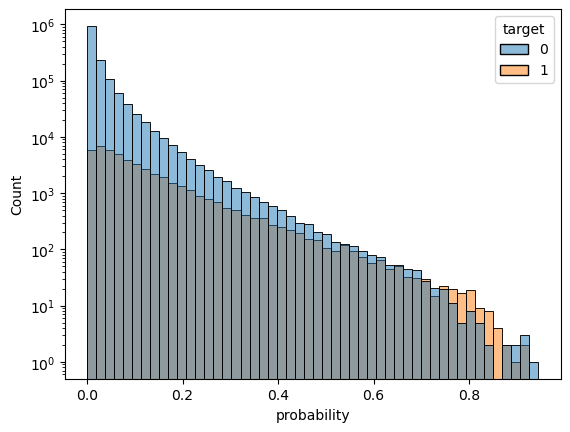

In [13]:
display(oof)
print(oof['probability'].describe())

_, ax = plt.subplots()
sns.histplot(data=oof, x='probability', hue='target', bins=50, ax=ax)
plt.yscale('log')
plt.show()

,fold_1_fimp,fold_2_fimp,fold_3_fimp,fold_4_fimp,fold_5_fimp,fimp_mean,fimp_std
personindex_1023L_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mastercontrelectronic_519L_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mastercontrexist_109L_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
outstandingamount_354A_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
overdueamount_31A_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
overdueamountmax_155A_1,8044.246902,10278.366586,9874.608341,10244.08454,10633.373105,9814.935895,917.352314
pmtnum_254L_0,10117.662024,11558.028876,10340.742229,10309.903605,11183.84943,10702.037233,564.032257
price_1097A_0,15394.252024,17088.097522,15532.264152,17504.548259,15918.031022,16287.438596,851.697516
dpdmax_139P_1,22780.665033,21494.436419,20901.952681,24021.323479,20553.906897,21950.456902,1283.386272


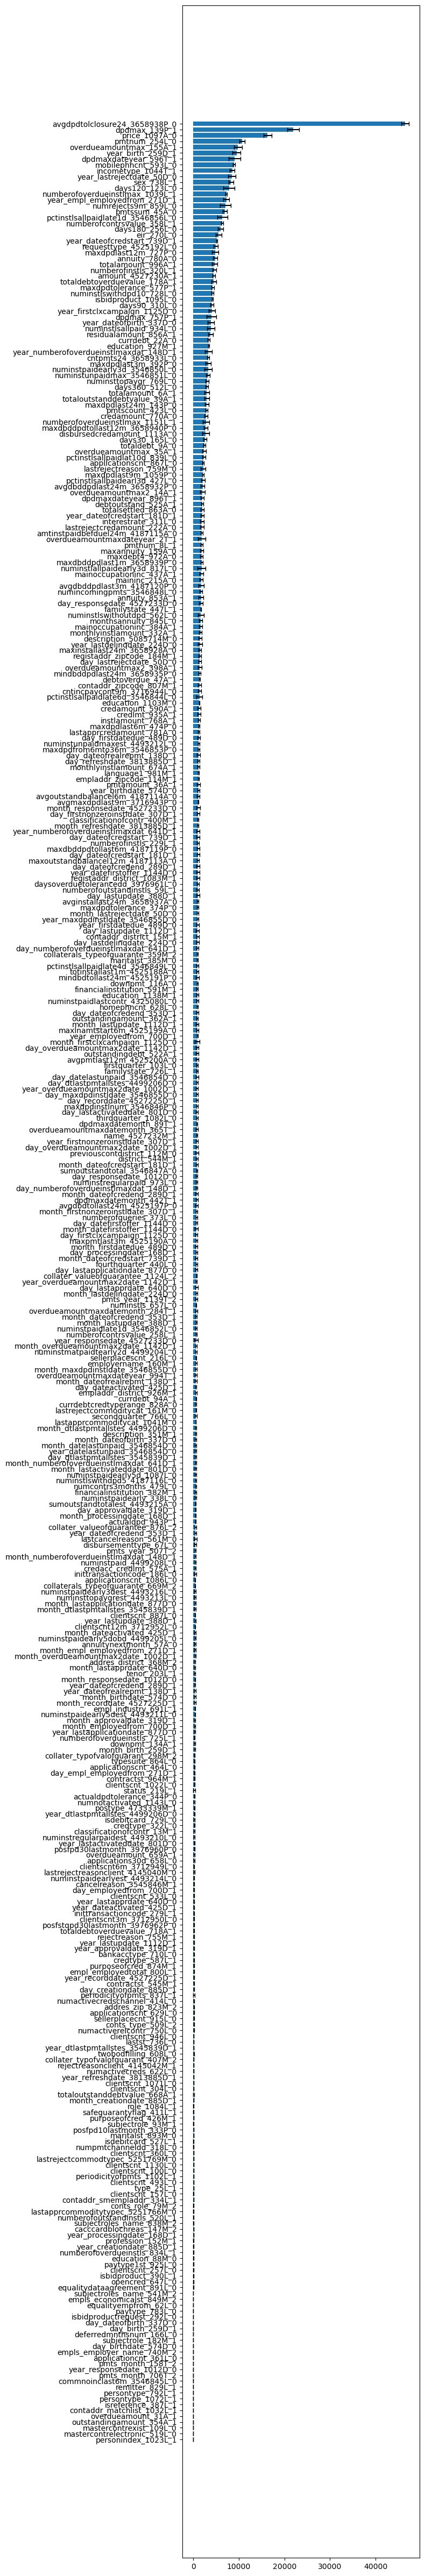

In [14]:
fimps['fimp_mean'] = fimps.mean(axis=1)
fimps['fimp_std'] = fimps.std(axis=1)
fimps.sort_values('fimp_mean', inplace=True)
display(fimps)

_, ax = plt.subplots(figsize=(8, 16*(len(fimps)//100)))
ax.barh(y=fimps.index, width=fimps['fimp_mean'], xerr=fimps['fimp_std'], capsize=3)
plt.tight_layout()
plt.show()

In [15]:
oof.to_csv(paths.output_dir.joinpath('oof.csv'), index=False)

fimps = fimps.reset_index(names=['processed_Variable'])
fimps.to_csv(paths.output_dir.joinpath('feature_importances.csv'), index=False)

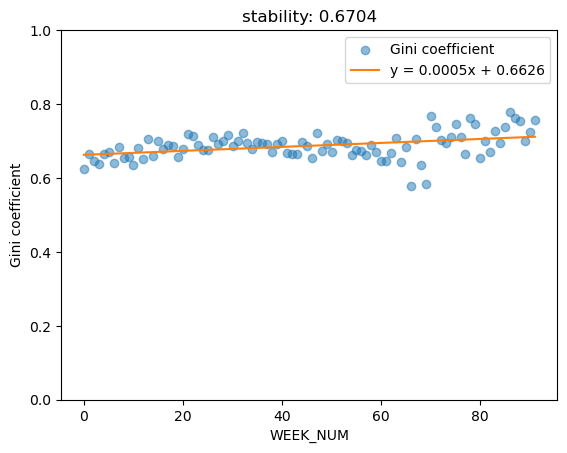

,WEEK_NUM,gini,regression,residuals
0,0,0.623401,0.662555,-0.039154
1,1,0.665415,0.663092,0.002323
2,2,0.645978,0.663629,-0.017651
3,3,0.639101,0.664167,-0.025065
4,4,0.664756,0.664704,0.000052
...,...,...,...,...
87,87,0.762967,0.709292,0.053674
88,88,0.753623,0.709830,0.043793
89,89,0.700563,0.710367,-0.009803
90,90,0.724255,0.710904,0.013351


2024-04-17 20:38:18,061 scripts.get_logger:6 <module> [INFO]:
stability: 0.6704469123148374
slope: 0.0005372110359245465
intercept: 0.6625550096950074



   stability     slope  intercept
0   0.670447  0.000537   0.662555


In [16]:
evaluater = Evaluator(oof)
gini_per_week, outcome = evaluater.plot_gini()
display(gini_per_week)
print(outcome)

logger.info(
    f'stability: {outcome["stability"].item()}\n'
    + f'slope: {outcome["slope"].item()}\n'
    + f'intercept: {outcome["intercept"].item()}\n'
)

outcome.to_csv(paths.output_dir.joinpath('outcome.csv'), index=False)